<a href="https://colab.research.google.com/github/syakibb/PCD/blob/main/PCD_Pertemuan_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PCD - Pertemuan 10**

## Import Library

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Latihan 1

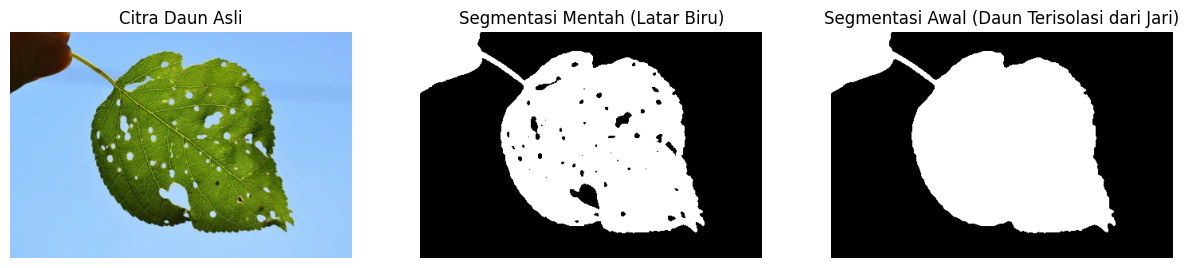

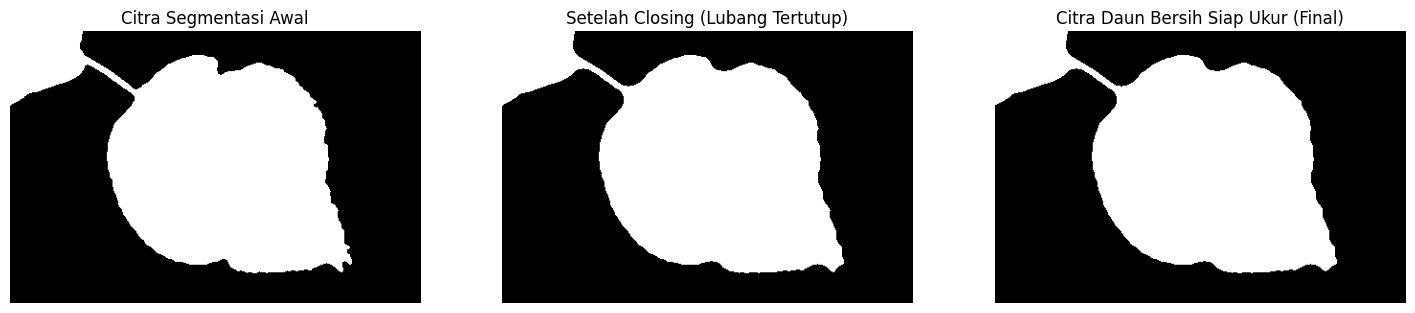

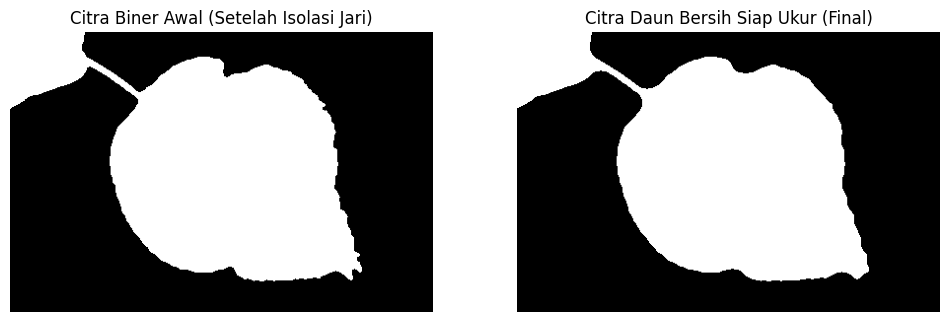

Pengolahan citra daun selesai. Citra 'leaf_final_cleaned' adalah hasil akhir yang bersih dan siap diukur.


In [12]:
# --- 1. Muat Citra dan Lakukan Segmentasi Awal ---
# Membaca citra daun
leaf_original = cv2.imread('daun.png')

# Memeriksa apakah citra berhasil dimuat
if leaf_original is None:
    print("Error: Gambar 'daun.png' tidak ditemukan. Pastikan file berada di direktori yang sama.")
else:
    # Konversi BGR ke RGB untuk tampilan di Matplotlib
    leaf_rgb = cv2.cvtColor(leaf_original, cv2.COLOR_BGR2RGB)

    # Konversi BGR ke HSV untuk segmentasi berbasis warna (lebih baik untuk pemisahan warna)
    leaf_hsv = cv2.cvtColor(leaf_original, cv2.COLOR_BGR2HSV)

    # Menentukan rentang warna biru untuk latar belakang (nilai ini mungkin perlu penyesuaian)
    # Hue: 90-130 (biru), Saturation: 50-255 (warna pekat), Value: 50-255 (terang)
    lower_blue = np.array([90, 50, 50])
    upper_blue = np.array([130, 255, 255])

    # Membuat masker biner di mana piksel dalam rentang warna biru menjadi putih
    mask_blue = cv2.inRange(leaf_hsv, lower_blue, upper_blue)

    # Menginvers masker untuk mendapatkan objek daun (daun menjadi putih, latar belakang menjadi hitam)
    leaf_segmented_raw = cv2.bitwise_not(mask_blue)

    # --- 2. Pra-pemrosesan Masker (Menghilangkan Objek Asing seperti Jari) ---
    # Tujuan: Mengisolasi daun dari objek lain (misal: jari) yang mungkin ikut tersegmentasi.

    # A. Initial Closing pada masker mentah untuk konsolidasi dan mengisi celah tipis,
    # ini membantu agar kontur daun terdeteksi sebagai satu kesatuan yang lebih baik.
    kernel_initial_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5)) # Kernel elips kecil
    leaf_pre_contour = cv2.morphologyEx(leaf_segmented_raw, cv2.MORPH_CLOSE, kernel_initial_close)

    # B. Analisis Kontur: Menemukan dan mempertahankan hanya kontur terbesar (asumsi itu adalah daun).
    contours, hierarchy = cv2.findContours(leaf_pre_contour, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    leaf_isolated = np.zeros_like(leaf_segmented_raw) # Membuat citra biner kosong dengan ukuran yang sama
    if contours:
        max_area = 0
        largest_contour = None
        for contour in contours:
            area = cv2.contourArea(contour)
            if area > max_area:
                max_area = area
                largest_contour = contour

        # Menggambar ulang hanya kontur terbesar ke citra kosong
        if largest_contour is not None:
            cv2.drawContours(leaf_isolated, [largest_contour], -1, 255, cv2.FILLED)

    # Tampilkan hasil segmentasi awal dan isolasi daun
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(leaf_rgb)
    plt.title('Citra Daun Asli')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(leaf_segmented_raw, cmap='gray')
    plt.title('Segmentasi Mentah (Latar Biru)')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(leaf_isolated, cmap='gray')
    plt.title('Segmentasi Awal (Daun Terisolasi dari Jari)')
    plt.axis('off')
    plt.show()

    # --- 3. Menutup Lubang Utama di Dalam Objek Daun ---
    # Tujuan: Mengisi semua lubang (baik yang kecil maupun yang besar) di dalam daun.
    # Menggunakan kernel elips besar untuk menutup lubang dengan bentuk lebih alami.
    kernel_close_holes = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (25,25)) # Sesuaikan ukuran ini!
    leaf_holes_filled = cv2.morphologyEx(leaf_isolated, cv2.MORPH_CLOSE, kernel_close_holes)

    # --- 4. Menghaluskan Tepi Objek dan Menghilangkan Noise Kecil ---
    # Tujuan: Memperhalus tepi daun yang mungkin kasar dan menghilangkan titik-titik noise kecil.
    # Menggunakan kernel elips yang lebih kecil untuk smoothing dan menghilangkan noise.
    kernel_open_smooth_noise = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,7)) # Sesuaikan ukuran ini!
    leaf_smoothed_cleaned = cv2.morphologyEx(leaf_holes_filled, cv2.MORPH_OPEN, kernel_open_smooth_noise)

    # --- 5. Penyempurnaan Akhir (Opsional) ---
    # Tujuan: Mengatasi sisa-sisa masalah yang sangat minor atau memperbaiki sedikit distorsi.
    # Misalnya, Closing kecil tambahan jika ada lubang sangat kecil yang muncul kembali, atau untuk "menebalkan" tepi sedikit.
    kernel_final_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    leaf_final_cleaned = cv2.morphologyEx(leaf_smoothed_cleaned, cv2.MORPH_CLOSE, kernel_final_close)

    # --- Tampilkan Hasil Akhir dan Perbandingan ---
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(leaf_isolated, cmap='gray')
    plt.title('Citra Segmentasi Awal')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(leaf_holes_filled, cmap='gray')
    plt.title('Setelah Closing (Lubang Tertutup)')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(leaf_final_cleaned, cmap='gray')
    plt.title('Citra Daun Bersih Siap Ukur (Final)')
    plt.axis('off')
    plt.show()

    # Perbandingan citra awal (setelah isolasi) dan citra akhir
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(leaf_isolated, cmap='gray')
    plt.title('Citra Biner Awal (Setelah Isolasi Jari)')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(leaf_final_cleaned, cmap='gray')
    plt.title('Citra Daun Bersih Siap Ukur (Final)')
    plt.axis('off')
    plt.show()

    print("Pengolahan citra daun selesai. Citra 'leaf_final_cleaned' adalah hasil akhir yang bersih dan siap diukur.")

## Latihan 2

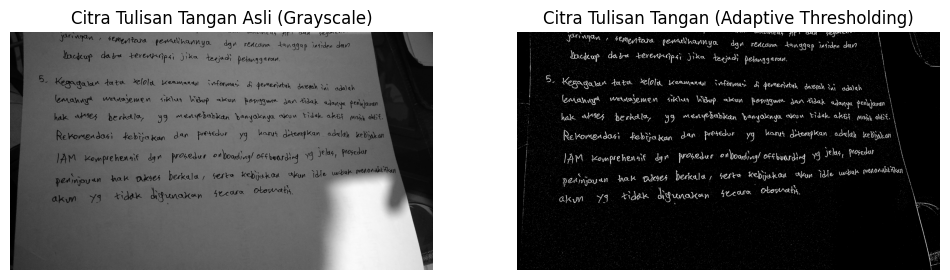

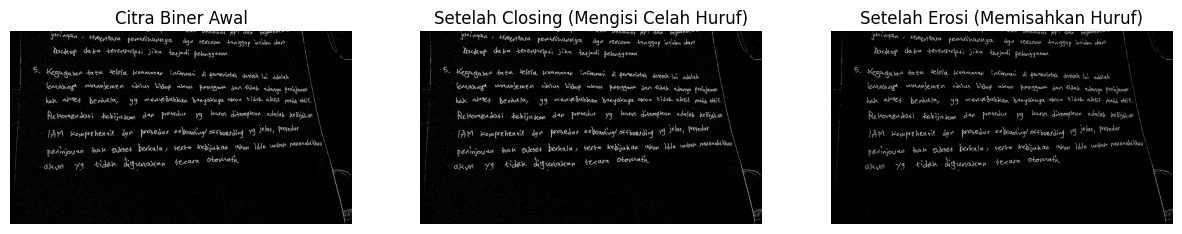

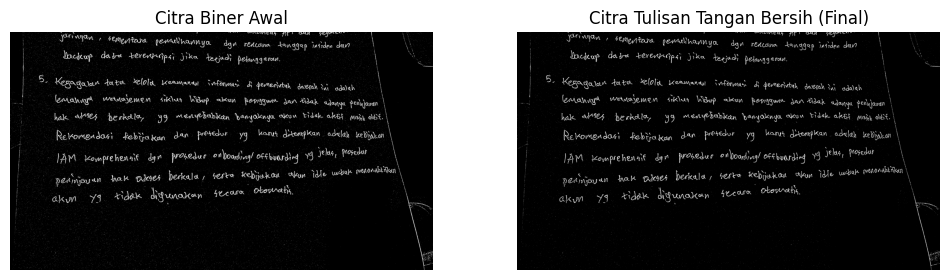

Pengolahan citra tulisan tangan selesai. Citra 'handwriting_separated' adalah hasil akhir yang bersih.


In [13]:
# --- 1. Muat Citra dan Terapkan Thresholding Adaptif ---
# Membaca citra tulisan tangan dalam mode grayscale
handwriting_original = cv2.imread('tulisan.png', cv2.IMREAD_GRAYSCALE)

# Memeriksa apakah citra berhasil dimuat
if handwriting_original is None:
    print("Error: Gambar 'tulisan.png' tidak ditemukan. Pastikan file berada di direktori yang sama.")
else:
    # Terapkan Adaptive Thresholding untuk mengatasi kualitas yang tidak seragam.
    # cv2.ADAPTIVE_THRESH_GAUSSIAN_C: Ambang batas adalah rata-rata tertimbang Gaussian dari lingkungan.
    # cv2.THRESH_BINARY_INV: Digunakan agar tulisan menjadi putih (objek) dan latar belakang menjadi hitam.
    # blockSize: Ukuran lingkungan di mana ambang batas dihitung. Harus ganjil (misal: 11, 15, 21).
    # C: Konstanta yang dikurangi dari rata-rata tertimbang atau mean (misal: 2, 4, 10).
    handwriting_thresh = cv2.adaptiveThreshold(handwriting_original, 255,
                                               cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                               cv2.THRESH_BINARY_INV, 21, 10) # Sesuaikan blockSize dan C

    # Tampilkan citra asli dan hasil thresholding
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(handwriting_original, cmap='gray')
    plt.title('Citra Tulisan Tangan Asli (Grayscale)')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(handwriting_thresh, cmap='gray')
    plt.title('Citra Tulisan Tangan (Adaptive Thresholding)')
    plt.axis('off')
    plt.show()

    # --- 2. Tentukan Strategi Operasi Morfologi dan Implementasikan ---

    # Definisi Kernel (Structuring Element)
    # Gunakan kernel elips untuk hasil yang lebih halus pada bentuk huruf
    # Kernel untuk Closing (mengisi celah/bagian putus, memperjelas bentuk)
    # Ukuran 3x3 atau 5x5 biasanya cukup untuk mengisi celah pada huruf.
    kernel_close_fill = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))

    # Kernel untuk Opening/Erosion (memisahkan huruf yang menempel)
    # Untuk pemisahan, kernel horizontal tipis seringkali efektif
    # Ini harus digunakan dengan sangat hati-hati agar tidak membuat huruf putus
    kernel_separate = cv2.getStructuringElement(cv2.MORPH_RECT, (2,1)) # Kernel 2x1 (sangat tipis, horizontal)


    # --- Urutan Operasi Morfologi ---

    # A. Closing: Mengisi bagian yang putus pada huruf dan memperjelas bentuk
    # Ini adalah langkah pertama untuk membuat huruf lebih "utuh".
    # Iterasi 1-2 kali biasanya cukup.
    handwriting_filled = cv2.morphologyEx(handwriting_thresh, cv2.MORPH_CLOSE, kernel_close_fill, iterations=1)

    # B. Erosion (Opsional): Memisahkan huruf-huruf yang saling menempel
    # Jika ada banyak huruf yang menempel, Anda bisa mencoba erosi.
    # Namun, erosi akan menipiskan huruf dan bisa membuat bagian yang sudah utuh jadi putus lagi.
    # Gunakan sangat hati-hati dan dengan kernel yang sangat kecil/spesifik (misal: horizontal).
    # Hasil dari tahap A akan di-erode.
    handwriting_separated = cv2.erode(handwriting_filled, kernel_separate, iterations=1)


    # --- Tampilkan Hasil Setiap Langkah ---
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(handwriting_thresh, cmap='gray')
    plt.title('Citra Biner Awal')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(handwriting_filled, cmap='gray')
    plt.title('Setelah Closing (Mengisi Celah Huruf)')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(handwriting_separated, cmap='gray')
    plt.title('Setelah Erosi (Memisahkan Huruf)')
    plt.axis('off')
    plt.show()

    # Perbandingan hasil akhir dengan citra biner awal
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(handwriting_thresh, cmap='gray')
    plt.title('Citra Biner Awal')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(handwriting_separated, cmap='gray')
    plt.title('Citra Tulisan Tangan Bersih (Final)')
    plt.axis('off')
    plt.show()

    print("Pengolahan citra tulisan tangan selesai. Citra 'handwriting_separated' adalah hasil akhir yang bersih.")